#### Financial markets are significantly influenced by public perception, news, and social media activity. With the increasing volume of tweets related to financial markets and specific stocks, we have a unique opportunity to explore the relationship between Twitter sentiment and stock market movements. By quantifying sentiment from Twitter data, we aim to uncover insights that could help predict future stock price trends, providing valuable information for investors and traders.



In [246]:
import pandas as pd
import re
import nltk
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [2]:
df=pd.read_csv(r"C:\Users\sony\Downloads\Final_project\stock_tweets.csv")

In [3]:
df

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [4]:
df.isnull().sum()

Date            0
Tweet           0
Stock Name      0
Company Name    0
dtype: int64

## Data cleaning 

In [5]:
# Define the cleaning function
def clean_text(text):
    # Convert text to lowercase (optional; can be removed if case matters for certain words)
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (e.g., #hashtag, but keep the word without #)
    text = re.sub(r'#', '', text)    
        
    # Remove non-ASCII characters (optional; useful only if dealing with special symbols)
    text = text.encode('ascii', 'ignore').decode('ascii')
    
    # Remove extra whitespace
    text = " ".join(text.split())
    
    return text



In [6]:
# Apply the cleaning function to the 'Tweet' column
df['Cleaned_Tweet'] = df['Tweet'].apply(clean_text)
print(df[ 'Cleaned_Tweet'])

0        mainstream media has done an amazing job at br...
1        tesla delivery estimates are at around 364k fr...
2        3/ even if i include 63.0m unvested rsus as of...
3        hahaha why are you still trying to stop tesla ...
4        stop trying to kill kids, you sad deranged old...
                               ...                        
80788    some of the fastest growing tech stocks on the...
80789    with earnings on the horizon, here is a quick ...
80790    our record delivery results are a testimony of...
80791    we delivered 10,412 smart evs in sep 2021, rea...
80792    why can xpeng p5 deliver outstanding performan...
Name: Cleaned_Tweet, Length: 80793, dtype: object


In [7]:
df

,Date,Tweet,Stock Name,Company Name,Cleaned_Tweet
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",mainstream media has done an amazing job at br...
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",tesla delivery estimates are at around 364k fr...
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",3/ even if i include 63.0m unvested rsus as of...
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",hahaha why are you still trying to stop tesla ...
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.","stop trying to kill kids, you sad deranged old..."
...,...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.,some of the fastest growing tech stocks on the...
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.,"with earnings on the horizon, here is a quick ..."
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.,our record delivery results are a testimony of...
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.,"we delivered 10,412 smart evs in sep 2021, rea..."


# Sentiment analysis  

In [ ]:
# Save the DataFrame to a CSV file
df.to_csv('stock sentiment10.csv', index=False)

print("Data saved to sentiment_analysis_results.csv")

In [8]:
sentiment_data=pd.read_csv(r"C:\Users\sony\Downloads\stock sentiment10.csv")

In [9]:
sentiment_data

,Date,Tweet,Stock Name,Company Name,Cleaned_Tweet,Sentiment_Score,Negative,Neutral,Positive
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",mainstream media has done an amazing job at br...,0.348784,0.464329,0.373774,0.161897
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",tesla delivery estimates are at around 364k fr...,0.545740,0.017830,0.872859,0.109311
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",3/ even if i include 63.0m unvested rsus as of...,0.478389,0.086374,0.870474,0.043152
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",hahaha why are you still trying to stop tesla ...,0.026991,0.951288,0.043443,0.005269
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.","stop trying to kill kids, you sad deranged old...",0.013704,0.975343,0.021905,0.002752
...,...,...,...,...,...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.,some of the fastest growing tech stocks on the...,0.967666,0.001599,0.061470,0.936931
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.,"with earnings on the horizon, here is a quick ...",0.750846,0.005826,0.486656,0.507518
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.,our record delivery results are a testimony of...,0.919306,0.002815,0.155757,0.841428
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.,"we delivered 10,412 smart evs in sep 2021, rea...",0.970046,0.001330,0.057248,0.941422


In [10]:
data = sentiment_data.drop([ 'Company Name', 'Tweet','Cleaned_Tweet'], axis=1)
data['Date'] = pd.to_datetime(data['Date']).dt.date
data

,Date,Stock Name,Sentiment_Score,Negative,Neutral,Positive
0,2022-09-29,TSLA,0.348784,0.464329,0.373774,0.161897
1,2022-09-29,TSLA,0.545740,0.017830,0.872859,0.109311
2,2022-09-29,TSLA,0.478389,0.086374,0.870474,0.043152
3,2022-09-29,TSLA,0.026991,0.951288,0.043443,0.005269
4,2022-09-29,TSLA,0.013704,0.975343,0.021905,0.002752
...,...,...,...,...,...,...
80788,2021-10-07,XPEV,0.967666,0.001599,0.061470,0.936931
80789,2021-10-04,XPEV,0.750846,0.005826,0.486656,0.507518
80790,2021-10-01,XPEV,0.919306,0.002815,0.155757,0.841428
80791,2021-10-01,XPEV,0.970046,0.001330,0.057248,0.941422


In [204]:
# Calculate the mean sentiment score for each date
new_data = data.groupby(['Date', 'Stock Name'])['Sentiment_Score'].mean().reset_index()
new_data

,Date,Stock Name,Sentiment_Score
0,2021-09-30,AAPL,0.421965
1,2021-09-30,AMD,0.778178
2,2021-09-30,AMZN,0.582031
3,2021-09-30,DIS,0.506778
4,2021-09-30,GOOG,0.631353
...,...,...,...
5905,2022-09-29,PG,0.482942
5906,2022-09-29,PYPL,0.646830
5907,2022-09-29,TSLA,0.528529
5908,2022-09-29,TSM,0.568138


# Merge Data 

In [223]:
data2=pd.read_csv(r"C:\Users\sony\Downloads\Final_project\stock_yfinance_data.csv")
data2

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA
...,...,...,...,...,...,...,...,...
6295,2022-09-23,13.090000,13.892000,12.860000,13.710000,13.710000,28279600,XPEV
6296,2022-09-26,14.280000,14.830000,14.070000,14.370000,14.370000,27891300,XPEV
6297,2022-09-27,14.580000,14.800000,13.580000,13.710000,13.710000,21160800,XPEV
6298,2022-09-28,13.050000,13.421000,12.690000,13.330000,13.330000,31799400,XPEV


In [224]:
new_data['Date'] = pd.to_datetime(new_data['Date'])
data2['Date'] = pd.to_datetime(data2['Date'])

# Merge the two datasets on 'Date' and 'Stock Name'
merged_data = pd.merge(data2, new_data, on=['Date', 'Stock Name'], how='inner')

# Display the merged dataset
print(merged_data)

           Date        Open        High         Low       Close   Adj Close  \
0    2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1    2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2    2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3    2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4    2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   
...         ...         ...         ...         ...         ...         ...   
4179 2022-08-30   18.280001   18.600000   17.950001   18.260000   18.260000   
4180 2022-09-07   15.750000   16.530001   15.630000   16.000000   16.000000   
4181 2022-09-12   16.549999   16.639999   15.980000   16.360001   16.360001   
4182 2022-09-19   14.300000   15.725000   14.290000   15.640000   15.640000   
4183 2022-09-26   14.280000   14.830000   14.070000   14.370000   14.370000   

        Volume Stock Name  Sentiment_Score  
0     

In [225]:
merged_data

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Sentiment_Score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,0.536834
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,0.589630
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,0.535443
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,0.540252
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,0.593652
...,...,...,...,...,...,...,...,...,...
4179,2022-08-30,18.280001,18.600000,17.950001,18.260000,18.260000,14484300,XPEV,0.351992
4180,2022-09-07,15.750000,16.530001,15.630000,16.000000,16.000000,14641500,XPEV,0.505971
4181,2022-09-12,16.549999,16.639999,15.980000,16.360001,16.360001,21170100,XPEV,0.761519
4182,2022-09-19,14.300000,15.725000,14.290000,15.640000,15.640000,18193100,XPEV,0.902618


In [226]:
merged_data.isnull().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
Stock Name         0
Sentiment_Score    0
dtype: int64

In [227]:
merged_data['Stock Name'].unique()

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [228]:
stocks_count=merged_data['Stock Name'].value_counts()
stocks_count

Stock Name
TSLA    252
PG      252
AMZN    252
AAPL    252
TSM     252
NIO     252
MSFT    252
AMD     249
GOOG    238
NFLX    228
META    219
PYPL    186
DIS     184
COST    157
BA      153
INTC    133
KO      133
CRM     116
ZS      102
XPEV     93
ENPH     87
VZ       65
BX       29
NOC      24
F        24
Name: count, dtype: int64

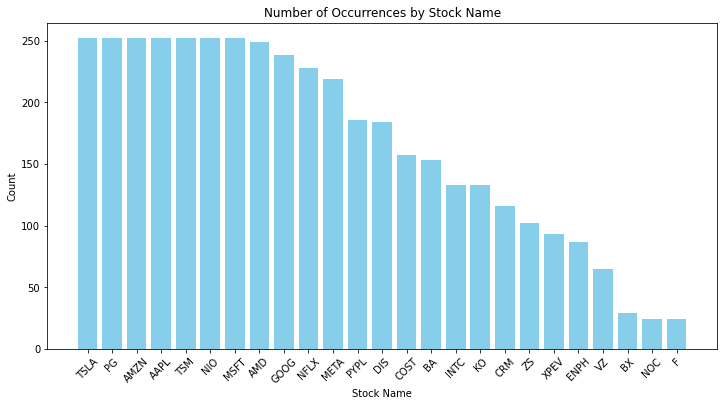

In [229]:
# Plotting
plt.figure(figsize=(12, 6))
plt.bar(stocks_count.index, stocks_count.values, color='skyblue')
plt.xticks(rotation=45)
plt.title('Number of Occurrences by Stock Name')
plt.xlabel('Stock Name')
plt.ylabel('Count')
plt.show()

In [230]:
merged_data.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment_Score
count,4184,4184.000000,4184.000000,4184.000000,4184.000000,4184.000000,4.184000e+03,4184.000000
mean,2022-03-29 05:25:55.640535296,180.767954,183.712568,177.614537,180.631801,179.970903,3.481762e+07,0.600599
min,2021-09-30 00:00:00,11.100000,11.360000,10.930000,11.130000,10.906092,5.832000e+05,0.011695
25%,2021-12-29 00:00:00,102.117498,103.920002,100.027500,101.852501,101.654781,8.373700e+06,0.515345
50%,2022-03-28 00:00:00,150.165878,152.295006,148.220001,150.154999,149.529999,2.135445e+07,0.589670
75%,2022-06-29 00:00:00,233.897499,239.610836,227.807503,234.386669,234.386669,5.392778e+07,0.681507
max,2022-09-29 00:00:00,692.349976,700.989990,686.090027,691.690002,691.690002,2.726620e+08,0.995132
std,NaN,127.237590,128.990809,125.238161,127.086738,126.892707,3.463913e+07,0.145765


In [231]:
# Define the function to plot the close price for any stock
def plot_close_price(stock_data, stock_name):
    # Ensure 'Date' column is in datetime format
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    
    # Filter the data for the specific stock
    filtered_data = stock_data[stock_data['Stock Name'] == stock_name]
    
    # Convert 'Date' and 'Close' columns to numpy arrays
    dates = filtered_data['Date'].values
    close_prices = filtered_data['Close'].values
    
    # Create the plot
    plt.figure(figsize=(16,8))
    plt.title(f"{stock_name} Close Price History", fontsize=16)
    plt.plot(dates, close_prices, label="Close Price", color='blue')
    
    # Format the x-axis to show dates nicely
    plt.xlabel('Date', fontsize=14)
    plt.ylabel("Close Price (USD)", fontsize=14)
    plt.xticks(rotation=45)
    
    # Adding grid for better readability
    plt.grid(True)
    
    # Format x-axis to display major ticks by month
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Add a legend
    plt.legend([f"{stock_name} Close Price"])
    
    # Display the plot
    plt.show()

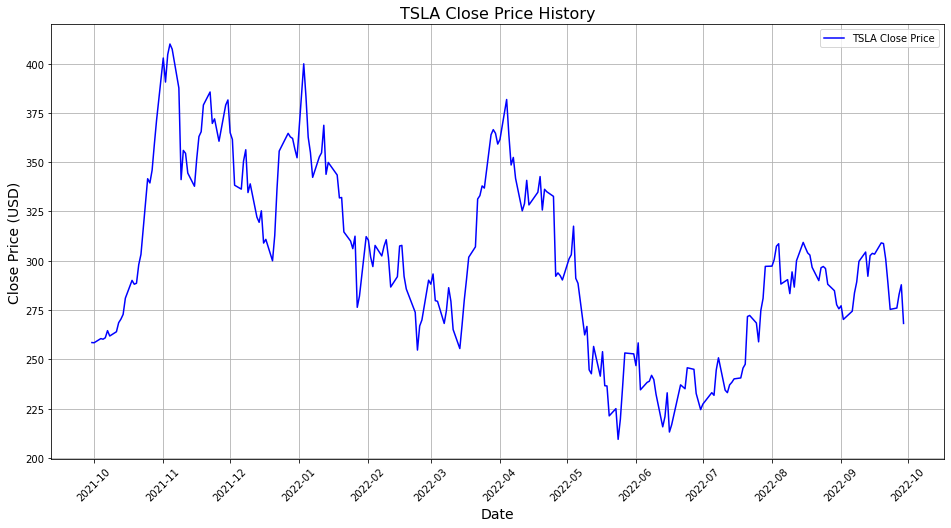

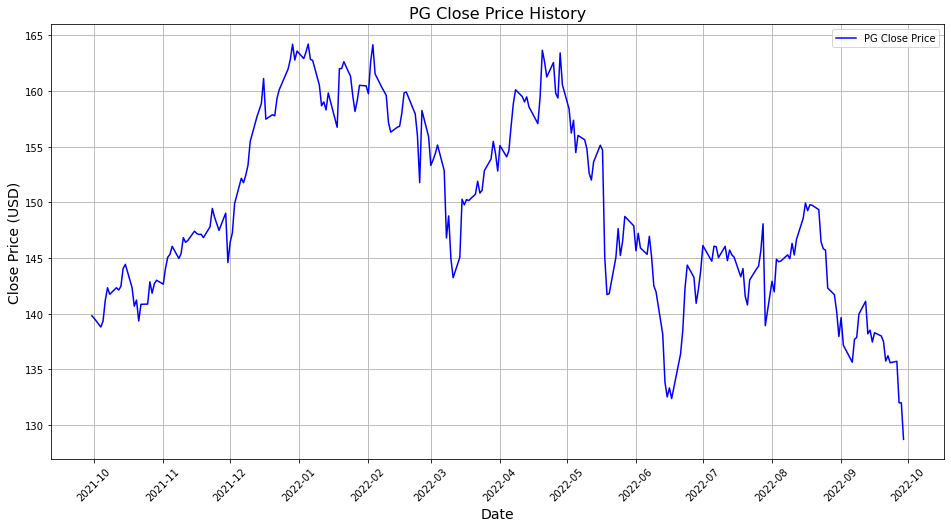

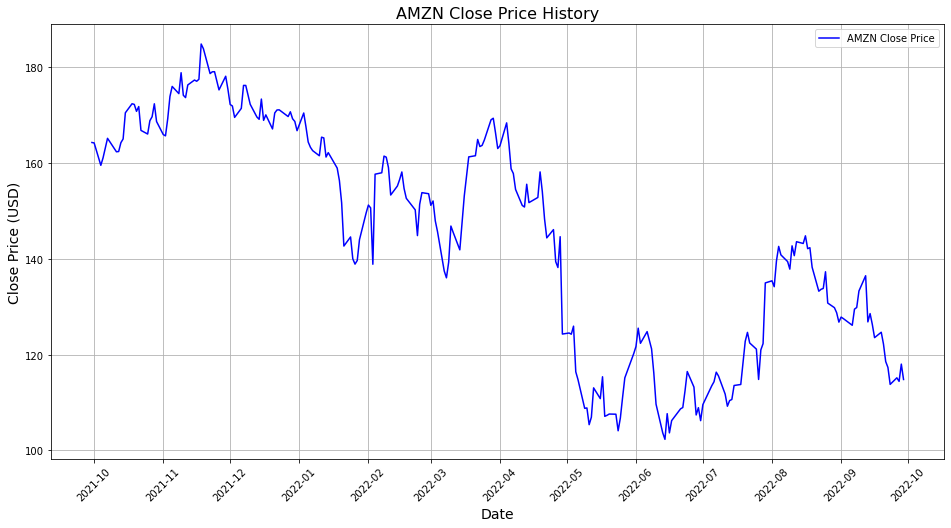

In [232]:
plot_close_price(merged_data, "TSLA")
plot_close_price(merged_data, "PG")
plot_close_price(merged_data, "AMZN")


# Relationship between the stock prices and sentiment score

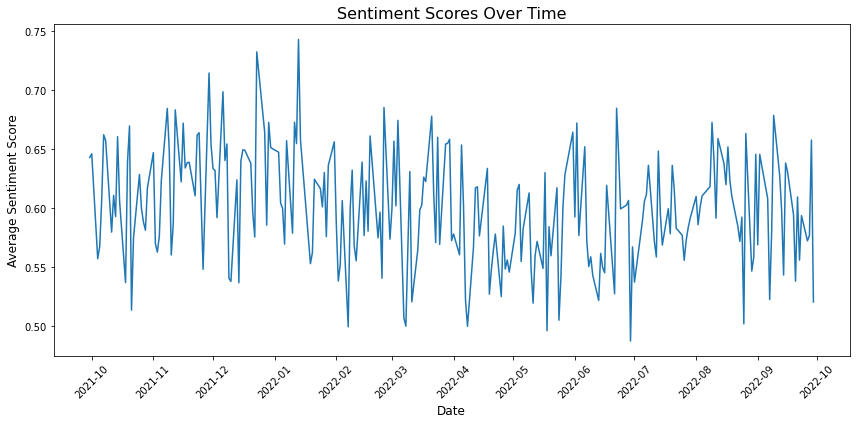

In [233]:
import matplotlib.dates as mdates

# Ensure the Date column is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

plt.figure(figsize=(12, 6))

# Plot the sentiment score over time without the confidence interval
sns.lineplot(x='Date', y='Sentiment_Score', data=merged_data, ci=None)

# Add labels and title
plt.title('Sentiment Scores Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)

# Improve the x-axis date formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()




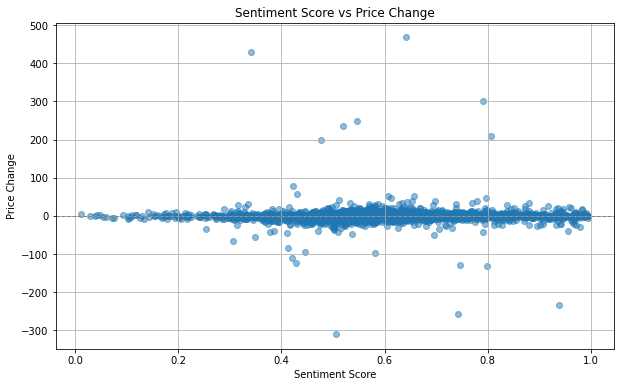

In [234]:
# Calculate price changes
merged_data['Price_Change'] = merged_data['Close'].diff()

# Example scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of sentiment score vs price change
plt.scatter(merged_data['Sentiment_Score'], merged_data['Price_Change'], alpha=0.5)
plt.title('Sentiment Score vs Price Change')
plt.xlabel('Sentiment Score')
plt.ylabel('Price Change')
plt.axhline(0, color='grey', lw=1, linestyle='--') 
plt.grid()
plt.show()


###### The plot doesn't show a strong linear relationship that changes in stock price are weakly influenced by sentiment scores

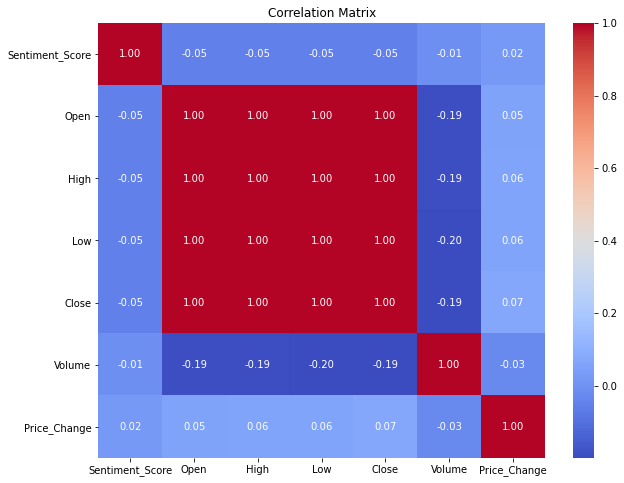

In [235]:
import seaborn as sns

# Select relevant columns for correlation
correlation_data = merged_data[['Sentiment_Score', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price_Change']]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


###### The matrix shows weak correlations between the Sentiment_Score and stock price indicators

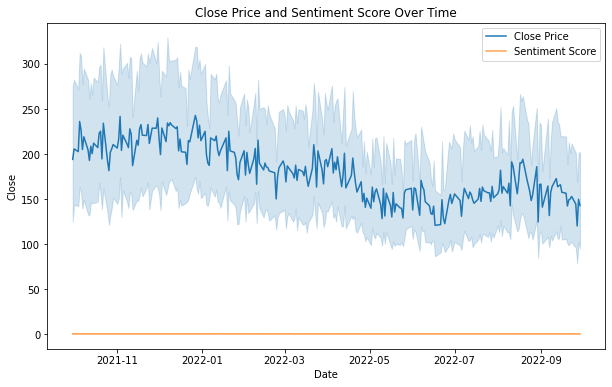

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Date', y='Close', label='Close Price')
sns.lineplot(data=merged_data, x='Date', y='Sentiment_Score', label='Sentiment Score', alpha=0.7)
plt.title('Close Price and Sentiment Score Over Time')
plt.legend()
plt.show()

######  the sentiment does not drastically influence price trends.

In [237]:
# Lag features: Shift sentiment score by 1 day, 3 days, and 7 days
merged_data['Sentiment_Lag_1'] = merged_data['Sentiment_Score'].shift(1)
merged_data['Sentiment_Lag_3'] = merged_data['Sentiment_Score'].shift(3)
merged_data['Sentiment_Lag_7'] = merged_data['Sentiment_Score'].shift(7)

# Lag features: Shift sentiment score by 1 day, 3 days, and 7 days
merged_data['Close_Lag_1'] = merged_data['Close'].shift(1)
merged_data['Close_Lag_3'] = merged_data['Close'].shift(3)
merged_data['Close_Lag_7'] = merged_data['Close'].shift(7)


In [238]:
# Moving Averages of Sentiment Scores
merged_data['Sentiment_Score_MA3'] = merged_data['Sentiment_Score'].rolling(window=3).mean()
merged_data['Sentiment_Score_MA7'] = merged_data['Sentiment_Score'].rolling(window=7).mean()
merged_data['Sentiment_Score_MA14'] = merged_data['Sentiment_Score'].rolling(window=14).mean()
# Moving Averages of Close Prices
merged_data['Close_MA3'] = merged_data['Close'].rolling(window=3).mean()
merged_data['Close_MA7'] = merged_data['Close'].rolling(window=7).mean()
merged_data['Close_MA14'] = merged_data['Close'].rolling(window=14).mean()


In [239]:
# Create volatility features
merged_data['Price_Volatility'] = merged_data['High'] - merged_data['Low']
merged_data['Sentiment_Volatility'] = merged_data['Sentiment_Score'].rolling(window=7).std()

In [240]:
merged_data = merged_data.dropna()
merged_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,Sentiment_Score,Price_Change,...,Close_Lag_3,Close_Lag_7,Sentiment_Score_MA3,Sentiment_Score_MA7,Sentiment_Score_MA14,Close_MA3,Close_MA7,Close_MA14,Price_Volatility,Sentiment_Volatility
13,2021-10-19,292.510010,292.649994,287.503326,288.089996,288.089996,52143300,TSLA,0.565987,-1.946686,...,272.773346,261.829987,0.587216,0.580561,0.574512,286.378896,276.403338,268.550956,5.146667,0.016244
14,2021-10-20,288.450012,289.829987,285.793335,288.600006,288.600006,42096300,TSLA,0.588880,0.510010,...,281.010010,263.980011,0.589345,0.583267,0.578230,288.908895,279.920480,270.701431,4.036652,0.015749
15,2021-10-21,285.333344,300.000000,285.166656,298.000000,298.000000,94444500,TSLA,0.603498,9.399994,...,290.036682,268.573334,0.586122,0.587032,0.579220,291.563334,284.124289,273.529526,14.833344,0.017131
16,2021-10-22,298.500000,303.333344,296.986664,303.226654,303.226654,68642400,TSLA,0.658858,5.226654,...,288.089996,270.359985,0.617079,0.599925,0.588036,296.608887,288.819528,276.580715,6.346680,0.030046
17,2021-10-25,316.843323,348.339996,314.733337,341.619995,341.619995,188556300,TSLA,0.654054,38.393341,...,288.600006,272.773346,0.638804,0.609563,0.596165,314.282216,298.654763,282.396667,33.606659,0.035399


In [241]:
# Drop non-numeric columns like 'Date' and 'Stock Name'
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns

# Calculate correlation matrix
correlation_matrix = merged_data[numeric_columns].corr()

# Correlation of features with Close price
correlation_with_close = correlation_matrix['Close'].sort_values(ascending=False)
print("Correlation Matrix:")
print(correlation_with_close)



Correlation Matrix:
Close                   1.000000
Adj Close               0.999963
Low                     0.999630
High                    0.999576
Open                    0.999152
Close_MA3               0.995013
Close_Lag_1             0.990943
Close_MA7               0.983214
Close_Lag_3             0.973525
Close_MA14              0.960214
Close_Lag_7             0.935863
Price_Volatility        0.666740
Price_Change            0.068146
Sentiment_Volatility    0.025068
Sentiment_Lag_1        -0.048745
Sentiment_Score        -0.049218
Sentiment_Lag_3        -0.049244
Sentiment_Lag_7        -0.058035
Sentiment_Score_MA3    -0.076026
Sentiment_Score_MA7    -0.104726
Sentiment_Score_MA14   -0.127583
Volume                 -0.195892
Name: Close, dtype: float64


###### There doesn't seem to be a strong relationship between the stock's Close price and sentiment scores their lags

In [242]:
# Calculate Spearman correlation for all numeric columns
spearman_corr_matrix = merged_data[numeric_columns].corr(method='spearman')

# Print the Spearman correlation matrix
print("Spearman Correlation Matrix:")
# Correlation of features with Close price
correlation_with_close = spearman_corr_matrix['Close'].sort_values(ascending=False)

print(correlation_with_close)

Spearman Correlation Matrix:
Close                   1.000000
Adj Close               0.999865
Low                     0.999554
High                    0.999491
Open                    0.998976
Close_MA3               0.995256
Close_Lag_1             0.990119
Close_MA7               0.983567
Close_Lag_3             0.971466
Close_MA14              0.963143
Close_Lag_7             0.933033
Price_Volatility        0.780832
Price_Change            0.041315
Sentiment_Volatility   -0.051437
Sentiment_Score        -0.095983
Sentiment_Lag_3        -0.096761
Sentiment_Lag_1        -0.097142
Sentiment_Lag_7        -0.107013
Sentiment_Score_MA3    -0.140578
Sentiment_Score_MA7    -0.178956
Sentiment_Score_MA14   -0.208137
Volume                 -0.259388
Name: Close, dtype: float64


## Predective model

In [243]:
merged_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Stock Name', 'Sentiment_Score', 'Price_Change', 'Sentiment_Lag_1',
       'Sentiment_Lag_3', 'Sentiment_Lag_7', 'Close_Lag_1', 'Close_Lag_3',
       'Close_Lag_7', 'Sentiment_Score_MA3', 'Sentiment_Score_MA7',
       'Sentiment_Score_MA14', 'Close_MA3', 'Close_MA7', 'Close_MA14',
       'Price_Volatility', 'Sentiment_Volatility'],
      dtype='object')

<ipython-input-245-08e7cb6bd58f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data['Stock Name'] = le.fit_transform(merged_data['Stock Name'])


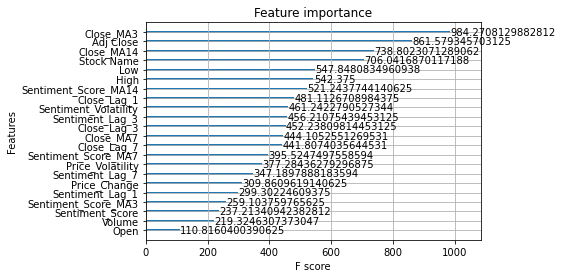

                 Feature  Importance
3              Adj Close    0.744290
2                    Low    0.138586
1                   High    0.111087
0                   Open    0.004376
11           Close_Lag_1    0.000915
17             Close_MA3    0.000213
18             Close_MA7    0.000157
12           Close_Lag_3    0.000094
5             Stock Name    0.000030
19            Close_MA14    0.000028
7           Price_Change    0.000025
21  Sentiment_Volatility    0.000025
16  Sentiment_Score_MA14    0.000023
15   Sentiment_Score_MA7    0.000022
10       Sentiment_Lag_7    0.000018
13           Close_Lag_7    0.000017
4                 Volume    0.000017
14   Sentiment_Score_MA3    0.000017
20      Price_Volatility    0.000016
9        Sentiment_Lag_3    0.000016
6        Sentiment_Score    0.000015
8        Sentiment_Lag_1    0.000014


In [245]:
# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'Stock Name' column
merged_data['Stock Name'] = le.fit_transform(merged_data['Stock Name'])

# Drop the 'Date' column and target column (Close price)
X = merged_data.drop(columns=['Close', 'Date'])  # Drop the target column (Close price) and 'Date'
y = merged_data['Close']  # Target column

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=4)
xgb_model.fit(X_train, y_train)

# Plot feature importance
xgb.plot_importance(xgb_model, importance_type='cover')  # You can choose 'weight', 'gain', or 'cover'
plt.show()

# Get feature importance values
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)



Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 25, 64)            18176     
                                                                 
 dropout_44 (Dropout)        (None, 25, 64)            0         
                                                                 
 lstm_45 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_45 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 51265 (200.25 KB)
Trainable params: 51265 (200.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequent

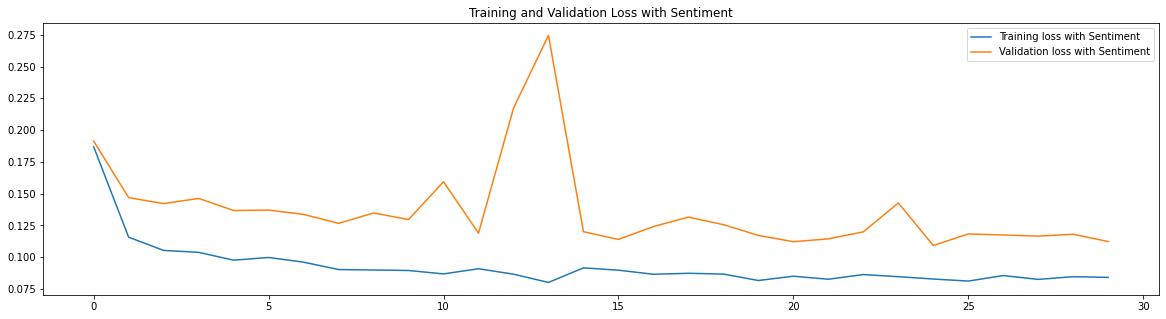

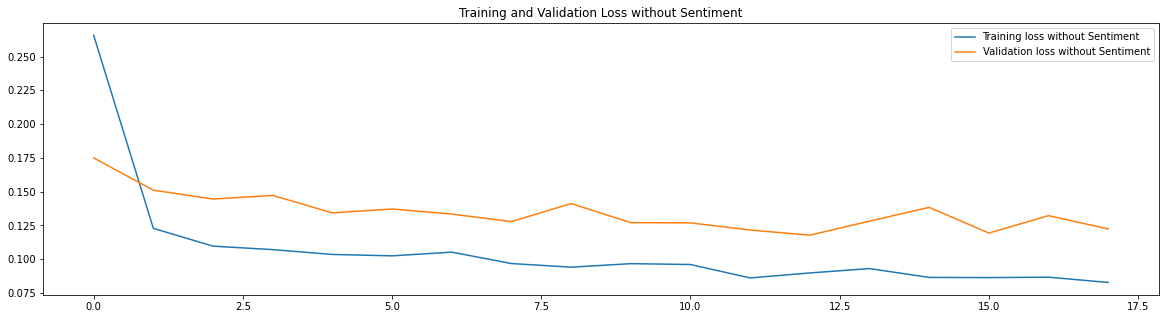

26/26 [==============================] - 1s 11ms/step


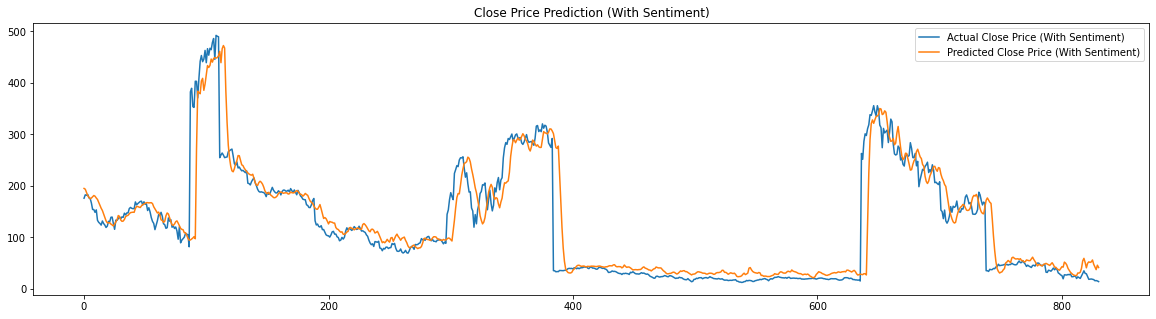

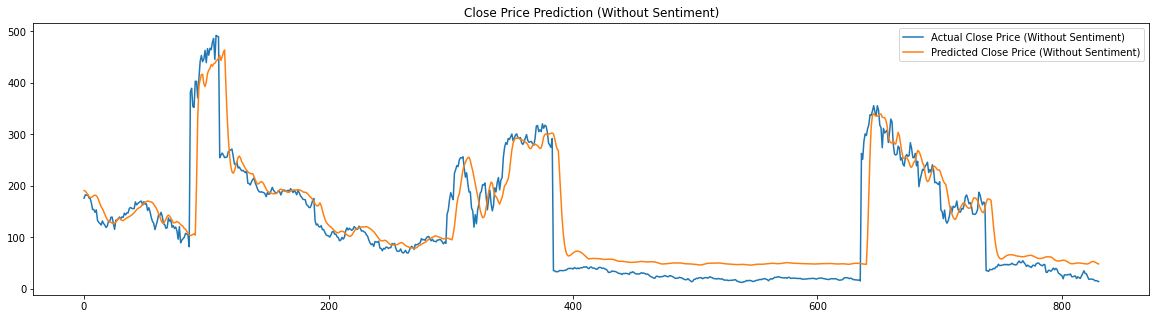

In [211]:
# Ensure Date is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data.set_index('Date', inplace=True)

# Define columns (with or without 'Sentiment_Score')
cols_with_sentiment = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Sentiment_Score']
cols_without_sentiment = ['Open', 'High', 'Low', 'Close', 'Adj Close']

# Dataframes for both cases (exclude 'Stock Name')
df_with_sentiment = merged_data[cols_with_sentiment].astype(float)
df_without_sentiment = merged_data[cols_without_sentiment].astype(float)

# Step 1: Scale the data using StandardScaler
scaler_with_sentiment = StandardScaler()
scaler_without_sentiment = StandardScaler()

df_with_sentiment_scaled = scaler_with_sentiment.fit_transform(df_with_sentiment)
df_without_sentiment_scaled = scaler_without_sentiment.fit_transform(df_without_sentiment)

# Set number of past days and future days
n_past = 25  
n_future = 5 

# Function to create sequences
def create_sequences(data, n_past, n_future, target_col_idx):
    X, y = [], []
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, :])  # Past sequence (all features)
        y.append(data[i + n_future - 1, target_col_idx])  # Targeting 'Close' column
    return np.array(X), np.array(y)

# Create sequences with and without sentiment
X_with_sentiment, y_with_sentiment = create_sequences(df_with_sentiment_scaled, n_past, n_future, 3)  # 'Close' column index is 3
X_without_sentiment, y_without_sentiment = create_sequences(df_without_sentiment_scaled, n_past, n_future, 3)

# Train/test/validation split (no shuffling for time series data)
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X_with_sentiment, y_with_sentiment, test_size=0.2, shuffle=False)
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(X_without_sentiment, y_without_sentiment, test_size=0.2, shuffle=False)

# Further split train data for validation
X_train_with, X_val_with, y_train_with, y_val_with = train_test_split(X_train_with, y_train_with, test_size=0.2, shuffle=False)
X_train_without, X_val_without, y_train_without, y_val_without = train_test_split(X_train_without, y_train_without, test_size=0.2, shuffle=False)

# Function to build LSTM model with hyperparameters
def build_lstm_model(input_shape, units=64, dropout_rate=0.3):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()

    return model

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build models with hyperparameters
lstm_model_with = build_lstm_model((X_train_with.shape[1], X_train_with.shape[2]), units=64, dropout_rate=0.3)
lstm_model_without = build_lstm_model((X_train_without.shape[1], X_train_without.shape[2]), units=64, dropout_rate=0.3)

# Train the model with sentiment
history_with = lstm_model_with.fit(X_train_with, y_train_with, epochs=100, batch_size=64, validation_data=(X_val_with, y_val_with), 
                                    callbacks=[early_stopping], verbose=1)

# Train the model without sentiment
history_without = lstm_model_without.fit(X_train_without, y_train_without, epochs=100, batch_size=64, validation_data=(X_val_without, y_val_without), 
                                          callbacks=[early_stopping], verbose=1)

# Plot training and validation loss for both models
plt.figure(figsize=(20,5))
plt.plot(history_with.history['loss'], label='Training loss with Sentiment')
plt.plot(history_with.history['val_loss'], label='Validation loss with Sentiment')
plt.title('Training and Validation Loss with Sentiment')
plt.legend()

plt.figure(figsize=(20,5))
plt.plot(history_without.history['loss'], label='Training loss without Sentiment')
plt.plot(history_without.history['val_loss'], label='Validation loss without Sentiment')
plt.title('Training and Validation Loss without Sentiment')
plt.legend()

plt.show()

# Make predictions
y_pred_with = lstm_model_with.predict(X_test_with)
y_pred_without = lstm_model_without.predict(X_test_without)

# Inverse scale the predictions and actual values for comparison
scaler_for_inference = StandardScaler()
scaler_for_inference.fit(df_with_sentiment[['Close']])  # Assuming 'Close' is in the scaled dataframe

y_pred_with_unscaled = scaler_for_inference.inverse_transform(y_pred_with)
y_test_with_unscaled = scaler_for_inference.inverse_transform(y_test_with.reshape(-1, 1))

y_pred_without_unscaled = scaler_for_inference.inverse_transform(y_pred_without)
y_test_without_unscaled = scaler_for_inference.inverse_transform(y_test_without.reshape(-1, 1))

# Plot predictions vs actuals for both models
plt.figure(figsize=(20,5))
plt.plot(y_test_with_unscaled, label='Actual Close Price (With Sentiment)')
plt.plot(y_pred_with_unscaled, label='Predicted Close Price (With Sentiment)')
plt.title('Close Price Prediction (With Sentiment)')
plt.legend()

plt.figure(figsize=(20,5))
plt.plot(y_test_without_unscaled, label='Actual Close Price (Without Sentiment)')
plt.plot(y_pred_without_unscaled, label='Predicted Close Price (Without Sentiment)')
plt.title('Close Price Prediction (Without Sentiment)')
plt.legend()

plt.show()


In [202]:
# Make predictions for the test set
y_pred_with = lstm_model_with.predict(X_test_with)
y_pred_without = lstm_model_without.predict(X_test_without)

# Inverse scale the predictions and actual values for comparison
scaler_for_inference = StandardScaler()
scaler_for_inference.fit(df_with_sentiment[['Close']]) 

y_pred_with_unscaled = scaler_for_inference.inverse_transform(y_pred_with)
y_test_with_unscaled = scaler_for_inference.inverse_transform(y_test_with.reshape(-1, 1))

y_pred_without_unscaled = scaler_for_inference.inverse_transform(y_pred_without)
y_test_without_unscaled = scaler_for_inference.inverse_transform(y_test_without.reshape(-1, 1))

# Print the last 5-day predictions for both models
print("Predicted Close prices for the next 5 days (With Sentiment):")
print(y_pred_with_unscaled[-5:])  # Last 5 predicted values with sentiment

print("\nPredicted Close prices for the next 5 days (Without Sentiment):")
print(y_pred_without_unscaled[-5:])  # Last 5 predicted values without sentiment


26/26 [==============================] - 0s 8ms/step
Predicted Close prices for the next 5 days (With Sentiment):
[[61.85879 ]
 [60.324978]
 [57.66293 ]
 [60.633503]
 [57.673832]]

Predicted Close prices for the next 5 days (Without Sentiment):
[[55.99818 ]
 [54.738407]
 [53.156612]
 [51.76003 ]
 [50.713566]]


### Predicted Close prices without sentiment is more stable and no relation between sentiment analysis and stock price market